In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from src.options import Options

import cv2
import numpy as np
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline  

from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.titlesize'] = 15

Enter the path to the model to test here

In [2]:
BEST_CHECKPOINT = '../io/models/1_run-batch_size_10/checkpoint.pth'

Enter the path to the images or sketchs here

In [3]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-1.png'
sketch_fname2 = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-2.png'

im_pos_fname = '../io/data/raw/Sketchy/extended_photo/airplane/ext_1.jpg'
im_pos_fname2 = '../io/data/raw/Sketchy/extended_photo/airplane/ext_2.jpg'

Process the image

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
def process_image(image_fname):
    image_pos = transform(default_image_loader(image_fname))
    return image_pos.unsqueeze(0)

In [6]:
im_log = process_image(im_pos_fname)
sk_log = process_image(sketch_fname)

If there are multiple images, process them all and concatenate them all here

In [7]:
im2 = process_image(im_pos_fname2)
sk2 = process_image(sketch_fname2)
sk_log = torch.cat((sk_log, sk2), dim=0)
im_log = torch.cat((im_log, im2), dim=0)

Load the best model

In [8]:
def get_model(best_checkpoint):
    im_net = EncoderCNN(out_size=256, attention=True)
    sk_net = EncoderCNN(out_size=256, attention=True)
    
    checkpoint = load_checkpoint(best_checkpoint)
    im_net.load_state_dict(checkpoint['im_state'])
    sk_net.load_state_dict(checkpoint['sk_state'])
    return im_net, sk_net

In [9]:
im_net, sk_net = get_model(BEST_CHECKPOINT)

=> loading model '../io/models/1_run-batch_size_10/checkpoint.pth'
=> loaded model '../io/models/1_run-batch_size_10/checkpoint.pth' (epoch 63, map 0.30450557342012813)


Get the attention weights on the image or sketch

In [10]:
def process_attention(net, im):
    _, attn_im = net(im)
    attn_im = nn.Upsample(size=(im[0].size(1), im[0].size(2)), mode='bilinear', align_corners=False)(attn_im)
    min_attn_im = attn_im.view((attn_im.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    max_attn_im = attn_im.view((attn_im.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    return (attn_im - min_attn_im) / (max_attn_im - min_attn_im)

In [11]:
attn_im = process_attention(im_net, im_log)
attn_sk = process_attention(sk_net, sk_log)

In [12]:
def pytorchtensor_to_pltarray(tensor):
    array = tensor.detach().numpy()
    return np.transpose(array, (1,2,0))

In [13]:
def pltarray_to_pytorchtensor(array):
    array = np.transpose(array, (2,0,1))
    return torch.tensor(array.copy())

## New implementation

In [15]:
colormap = 'Spectral_r'

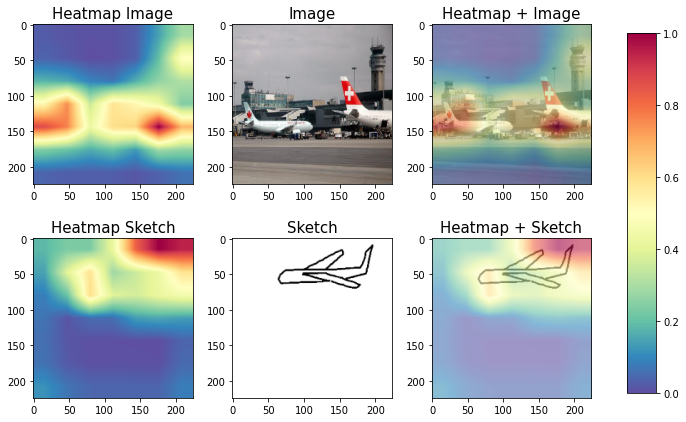

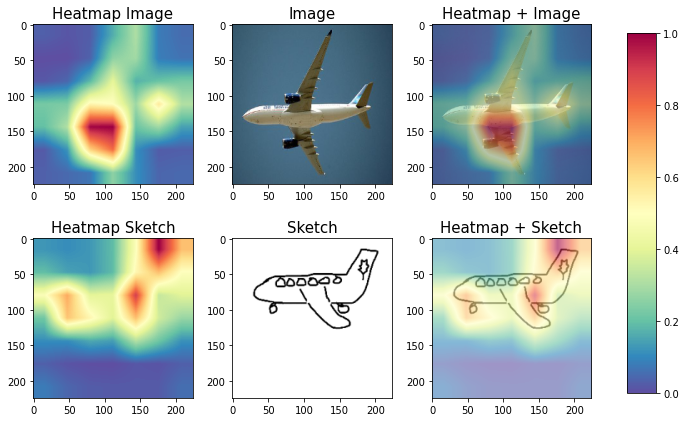

In [16]:
for i in range(im_log.size(0)): # number of images
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3) 
    
    # Heatmap Image
    heat_map_im = attn_im[i].squeeze().detach().numpy()
    heatmap = ax1.imshow(heat_map_im, cmap=colormap)
    ax1.set(title='Heatmap Image')
    
    # Image
    im = pytorchtensor_to_pltarray(im_log[i])
    ax2.imshow(im)
    ax2.set(title='Image')
    
    # Both: Heatmap + Image
    ax3.imshow(im)
    ax3.imshow(255 * heat_map_im, alpha=0.6, cmap=colormap)
    ax3.axis('on')
    ax3.set(title='Heatmap + Image')
    
    # Heatmap Sketch
    heat_map_sk = attn_sk[i].squeeze().detach().numpy()
    ax4.imshow(heat_map_sk, cmap=colormap)
    ax4.set(title='Heatmap Sketch')
    
    # Sketch 
    sk = pytorchtensor_to_pltarray(sk_log[i])
    ax5.imshow(sk)
    ax5.set(title='Sketch')
    
    # Both: Heatmap + Sketch
    ax6.imshow(sk)
    ax6.imshow(255 * heat_map_sk, alpha=0.6, cmap=colormap)
    ax6.axis('on')
    ax6.set(title='Heatmap + Sketch')
    
    plt.subplots_adjust(wspace=0.25, hspace=-0.35)
    
    cbar_ax = fig.add_axes([0.95, 0.25, 0.04, 0.5])
    fig.colorbar(heatmap, cax=cbar_ax)

    plt.show()

## Add to tensorboard

In [28]:
def add_heatmap_on_image(im, attn):
    heat_map = attn.squeeze().detach().numpy()
    im = im.detach().numpy()
    im = np.transpose(im, (1,2,0))

    # Heatmap + Image on figure
    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.imshow(255 * heat_map, alpha=0.8, cmap=colormap)
    ax.axis('off')
    plt.show()
    
    # Get value from canvas
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_from_plot = np.transpose(image_from_plot, (2,0,1))
    return torch.tensor(image_from_plot.copy())

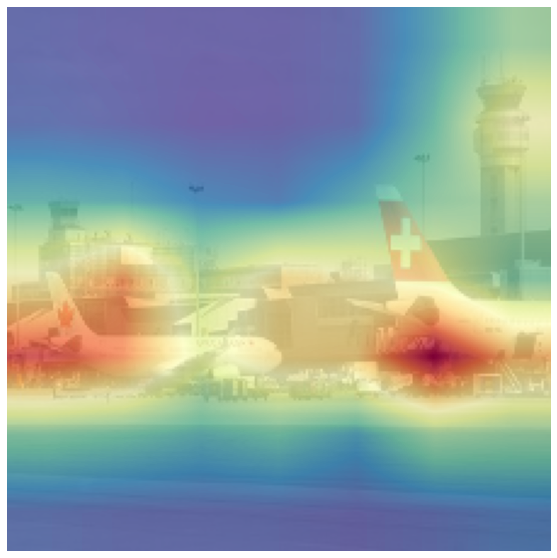

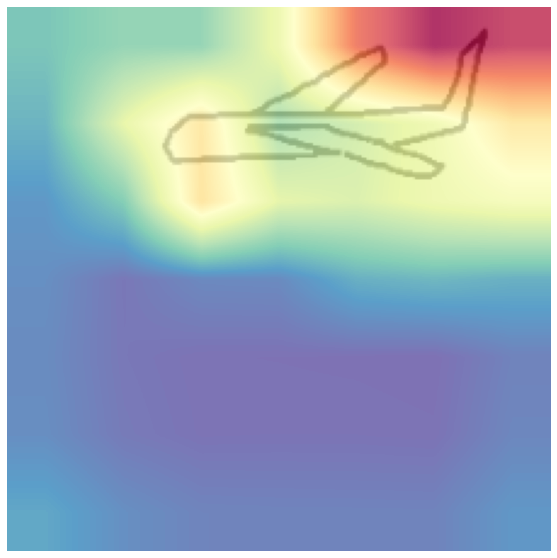

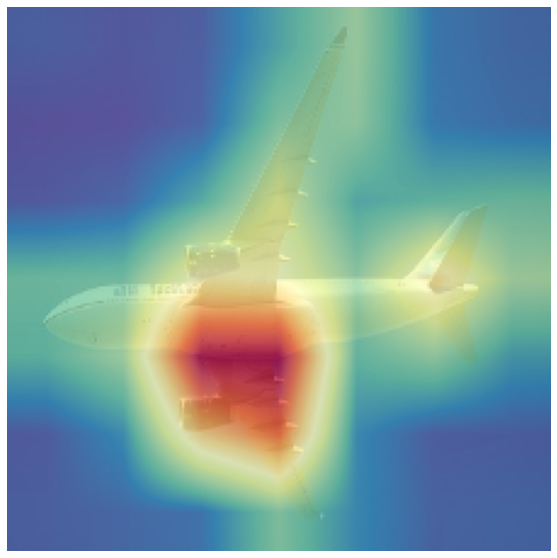

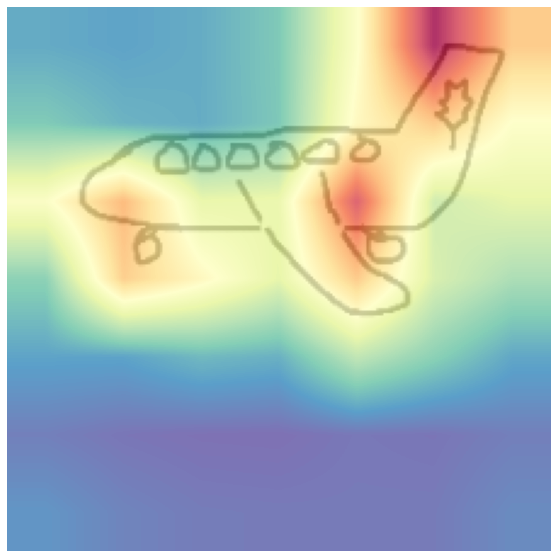

In [30]:
for i in range(im_log.size(0)):
    _ = add_heatmap_on_image(im_log[i], attn_im[i])
    _ = add_heatmap_on_image(sk_log[i], attn_sk[i])

## Previous implementation

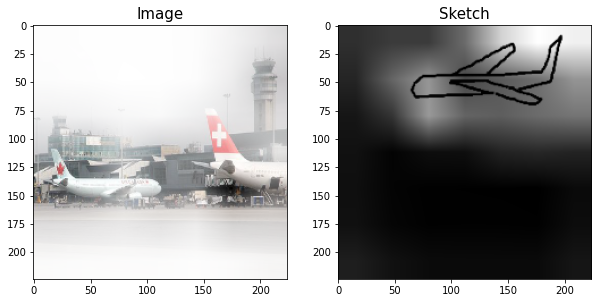

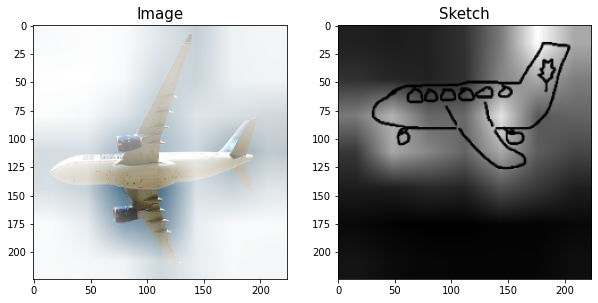

In [14]:
for i in range(im_log.size(0)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    # Image
    plt_im = torch.cat([im_log[i], attn_im[i]], dim=0)
    plt_im_t = pytorchtensor_to_pltarray(plt_im)
    ax1.imshow(plt_im_t)
    ax1.set(title='Image')
    
    # Sketch
    plt_sk = sk_log[i]*attn_sk[i]
    plt_sk_t = pytorchtensor_to_pltarray(plt_sk)
    ax2.imshow(plt_sk_t)
    ax2.set(title='Sketch')
    
    plt.show()